<a href="https://colab.research.google.com/github/AadityaBisaria/Einops_rearrange/blob/main/aaditya_rearrange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from typing import Dict, List, Tuple, Union, Optional
import re
from dataclasses import dataclass
from enum import Enum, auto

In [ ]:
class OperationType(Enum):
    """Types of operations that can be performed on axes."""
    SPLIT = auto()
    MERGE = auto()
    REPEAT = auto()
    TRANSPOSE = auto()

In [ ]:

@dataclass
class AxisOperation:
    """Represents an operation to be performed on an axis."""
    type: OperationType
    input_axes: List[str]
    output_axes: List[str]
    lengths: Optional[Dict[str, int]] = None
    group_name: Optional[str] = None  # Name for the group after merging


In [ ]:
class PatternNode:
    """Represents a node in the pattern parse tree."""
    def __init__(self, value: Union[str, List[str], List['PatternNode']], is_group: bool = False, is_ellipsis: bool = False):
        self.value = value
        self.is_group = is_group
        self.is_ellipsis = is_ellipsis
        self.parent = None
        if isinstance(value, list):
            for child in value:
                if isinstance(child, PatternNode):
                    child.parent = self

    def flatten(self) -> List[str]:
        """Flatten the tree into a sequence of axis names."""
        if self.is_ellipsis:
            return ['...']
        if isinstance(self.value, str):
            return [self.value]
        if self.is_group:
            # For groups, return a single string representing the group
            if isinstance(self.value, list):
                if all(isinstance(x, str) for x in self.value):
                    return ['(' + ' '.join(self.value) + ')']
                else:
                    return ['(' + ' '.join(child.value for child in self.value) + ')']
        return [axis for child in self.value for axis in child.flatten()]

    def get_axes(self) -> List[str]:
        """Get the individual axis names without grouping."""
        if self.is_ellipsis:
            return ['...']
        if isinstance(self.value, str):
            return [self.value]
        if self.is_group and isinstance(self.value, list):
            if all(isinstance(x, str) for x in self.value):
                return self.value
        return [axis for child in self.value for axis in child.get_axes()]

    def __repr__(self) -> str:
        if self.is_ellipsis:
            return '...'
        if isinstance(self.value, str):
            return self.value
        if self.is_group and isinstance(self.value, list):
            if all(isinstance(x, str) for x in self.value):
                return f"({' '.join(self.value)})"
        return f"({' '.join(str(child) for child in self.value)})"



In [ ]:
class PatternParser:
    """Parser for Einops-style rearrangement patterns."""

    def __init__(self):
        """Initialize the pattern parser."""
        pass

    def _parse_group(self, pattern: str, start: int = 0) -> Tuple[PatternNode, int]:
        """Parse a group of axes (enclosed in parentheses)."""
        if pattern[start] != '(':
            raise ValueError("Group must start with '('")

        # Find the matching closing parenthesis
        depth = 1
        pos = start + 1
        while pos < len(pattern) and depth > 0:
            if pattern[pos] == '(':
                depth += 1
            elif pattern[pos] == ')':
                depth -= 1
            pos += 1

        if depth != 0:
            raise ValueError("Unmatched parentheses in pattern")

        # Parse the contents of the group
        group_content = pattern[start+1:pos-1].strip()
        if not group_content:
            raise ValueError("Empty group in pattern")

        # Split the group content into individual axes
        axes = []
        current = []
        i = 0
        while i < len(group_content):
            # Check for ellipsis
            if group_content[i:i+3] == '...':
                if current:
                    axes.append(''.join(current))
                    current = []
                axes.append('...')
                i += 3
            elif group_content[i].isspace():
                if current:
                    axes.append(''.join(current))
                    current = []
                i += 1
            else:
                current.append(group_content[i])
                i += 1
        if current:
            axes.append(''.join(current))

        # Validate axis names
        for axis in axes:
            if not axis.isidentifier() and axis != '...':
                raise ValueError(f"Invalid axis name: {axis}")

        # Create a PatternNode for the group
        return PatternNode(value=axes, is_group=True), pos

    def _parse_pattern(self, pattern: str) -> List[PatternNode]:
        """Parse a pattern string into a list of PatternNode objects."""
        nodes = []
        pos = 0

        while pos < len(pattern):
            char = pattern[pos]

            if char.isspace():
                pos += 1
                continue

            # Check for ellipsis
            if pattern[pos:pos+3] == '...':
                nodes.append(PatternNode(value='...', is_ellipsis=True))
                pos += 3
                continue

            if char == '(':
                # Parse a group
                node, new_pos = self._parse_group(pattern, pos)
                nodes.append(node)
                pos = new_pos
            else:
                # Parse a single axis
                current = []
                while pos < len(pattern) and not pattern[pos].isspace() and pattern[pos] != '(' and pattern[pos:pos+3] != '...':
                    current.append(pattern[pos])
                    pos += 1

                if current:
                    axis = ''.join(current)
                    # Allow numeric literals as valid axis names
                    if not axis.isidentifier() and axis != '...' and not axis.isdigit():
                        raise ValueError(f"Invalid axis name: {axis}")
                    nodes.append(PatternNode(value=axis))

        return nodes

    def _get_grouped_axes(self, nodes: List[PatternNode]) -> List[List[str]]:
        """Get lists of axes that are grouped together."""
        grouped = []
        for node in nodes:
            if node.is_group:
                grouped.append(node.get_axes())
        return grouped

    def _get_ungrouped_axes(self, nodes: List[PatternNode]) -> List[str]:
        """Get axes that are not part of any group."""
        ungrouped = []
        for node in nodes:
            if not node.is_group:
                ungrouped.extend(node.get_axes())
        return ungrouped

    def _infer_transformations(self, input_nodes: List[PatternNode], output_nodes: List[PatternNode],
                             symbol_to_dim: Dict[str, int]) -> List[AxisOperation]:
        """Infer transformations by comparing input and output structures."""
        operations = []

        # Get flattened sequences for position comparison
        input_flat = [axis for node in input_nodes for axis in node.get_axes()]
        output_flat = [axis for node in output_nodes for axis in node.get_axes()]

        print(f"    Debug _infer_transformations:")
        print(f"    Input flat: {input_flat}")
        print(f"    Output flat: {output_flat}")

        # Track all axes that will exist after transformations
        existing_axes = set()
        for node in input_nodes:
            if node.is_group:
                existing_axes.update(node.get_axes())
            else:
                existing_axes.add(node.value)

        print(f"    Initial existing axes: {existing_axes}")

        # Create mapping of grouped axes to their positions
        input_groups_map = {}
        for i, node in enumerate(input_nodes):
            if node.is_group:
                group_axes = node.get_axes()
                group_name = '(' + ' '.join(group_axes) + ')'
                input_groups_map[group_name] = i

        print(f"    Input groups map: {input_groups_map}")

        # Get grouped axes in both patterns
        input_groups = []
        output_groups = []

        for node in input_nodes:
            if node.is_group:
                input_groups.append(node.get_axes())

        for node in output_nodes:
            if node.is_group:
                output_groups.append(node.get_axes())

        print(f"    Input groups: {input_groups}")
        print(f"    Output groups: {output_groups}")

        # Handle merges (ungrouped in input that are grouped in output)
        for group in output_groups:
            if not any(set(group).issubset(set(g)) for g in input_groups):
                print(f"    Found merge operation for group: {group}")
                # These axes need to be merged
                operations.append(AxisOperation(
                    type=OperationType.MERGE,
                    input_axes=group,  # Flattened list of axes
                    output_axes=group,  # Flattened list of axes
                    lengths={axis: symbol_to_dim[axis] for axis in group if axis in symbol_to_dim},
                    group_name='(' + ' '.join(group) + ')'
                ))
                # Update input_flat to reflect the merged axes
                group_name = '(' + ' '.join(group) + ')'
                for i, ax in enumerate(input_flat):
                    if ax in group:
                        input_flat[i] = group_name
                print(f"    Updated input flat after merge: {input_flat}")
                # Update existing axes tracking
                existing_axes.difference_update(group)
                existing_axes.add(group_name)

        # Handle splits (groups in input that are ungrouped in output)
        for group in input_groups:
            if not any(set(group).issubset(set(g)) for g in output_groups):
                print(f"    Found split operation for group: {group}")
                # Calculate missing dimensions for split
                lengths = {}
                known_size = 1
                unknown_axes = []

                # First pass: collect known dimensions
                for axis in group:
                    if axis in symbol_to_dim:
                        lengths[axis] = symbol_to_dim[axis]
                        known_size *= symbol_to_dim[axis]
                    else:
                        unknown_axes.append(axis)

                print(f"    Known dimensions: {lengths}")
                print(f"    Unknown axes: {unknown_axes}")

                # Check if we have multiple unknown dimensions
                if len(unknown_axes) > 1:
                    raise ValueError(f"Cannot infer multiple unknown sizes in group {group}")

                # Get the size of the original grouped dimension from the input shape
                group_name = '(' + ' '.join(group) + ')'
                group_idx = input_groups_map.get(group_name)
                if group_idx is not None and '_input_shape' in symbol_to_dim:
                    group_size = symbol_to_dim['_input_shape'][group_idx]
                    print(f"    Group size from input shape: {group_size}")

                    # If we have one unknown dimension, calculate it
                    if unknown_axes:
                        unknown_axis = unknown_axes[0]
                        # Calculate the unknown dimension
                        if known_size != 0:
                            lengths[unknown_axis] = group_size // known_size
                            print(f"    Calculated size for {unknown_axis}: {lengths[unknown_axis]}")
                        else:
                            raise ValueError(f"Cannot infer size for axis '{unknown_axis}' in group {group} because known dimensions multiply to zero")

                operations.append(AxisOperation(
                    type=OperationType.SPLIT,
                    input_axes=group,  # Flattened list of axes
                    output_axes=group,  # Flattened list of axes
                    lengths=lengths
                ))
                # Update existing axes tracking
                existing_axes.difference_update({group_name})
                existing_axes.update(group)

        print(f"    Existing axes after merge/split: {existing_axes}")

        # Now handle repeat operations for truly new axes
        for out_ax in output_flat:
            if out_ax in symbol_to_dim and out_ax not in existing_axes:
                # This is a genuinely new axis that needs to be added
                # Find a size-1 axis in the input to repeat
                for in_ax in input_flat:
                    if in_ax.isdigit() and int(in_ax) == 1:
                        operations.append(AxisOperation(
                            type=OperationType.REPEAT,
                            input_axes=[in_ax],
                            output_axes=[out_ax],
                            lengths={out_ax: symbol_to_dim[out_ax]}
                        ))
                        # Update input_flat to reflect the new axis name
                        input_flat[input_flat.index(in_ax)] = out_ax
                        print(f"    Found repeat operation for new axis: {in_ax} -> {out_ax}")
                        print(f"    Updated input flat: {input_flat}")
                        # Update existing axes tracking
                        existing_axes.difference_update({in_ax})
                        existing_axes.add(out_ax)
                        break

        print(f"    Existing axes after repeat: {existing_axes}")

        # Finally, handle transpositions (changes in axis order)
        # Get the final output axes, taking into account merged groups
        final_output_axes = []
        for node in output_nodes:
            if node.is_group:
                final_output_axes.append('(' + ' '.join(node.get_axes()) + ')')
            else:
                final_output_axes.append(node.value)

        # Remove duplicates from input_flat while preserving order
        seen = set()
        input_flat = [x for x in input_flat if not (x in seen or seen.add(x))]

        if input_flat != final_output_axes:
            print(f"    Found transpose operation:")
            print(f"    From: {input_flat}")
            print(f"    To: {final_output_axes}")
            operations.append(AxisOperation(
                type=OperationType.TRANSPOSE,
                input_axes=input_flat,
                output_axes=final_output_axes
            ))

        print(f"\n    Final operations:")
        for op in operations:
            print(f"    - {op.type}: {op.input_axes} -> {op.output_axes}")

        return operations

In [ ]:
def _apply_split(tensor: np.ndarray, operation: AxisOperation,
                axis_order: List[str]) -> Tuple[np.ndarray, List[str]]:
    """Apply a split operation to the tensor."""
    print(f"  Debug _apply_split:")
    print(f"    Input axes: {operation.input_axes}")
    print(f"    Output axes: {operation.output_axes}")
    print(f"    Current axis order: {axis_order}")

    # Find the index of the first axis in the group
    # We need to find a contiguous subsequence of axes in axis_order that matches operation.input_axes
    input_axes = operation.input_axes
    axis_idx = -1

    # Try to find a contiguous subsequence that matches the input axes
    for i in range(len(axis_order) - len(input_axes) + 1):
        if axis_order[i:i+len(input_axes)] == input_axes:
            axis_idx = i
            break

    if axis_idx == -1:
        # If we couldn't find a contiguous subsequence, try to find the axes individually
        # This is less ideal but handles cases where the axes might not be contiguous
        axis_indices = []
        for ax in input_axes:
            try:
                idx = axis_order.index(ax)
                axis_indices.append(idx)
            except ValueError:
                raise ValueError(f"Axis '{ax}' not found in axis order {axis_order}")

        # Use the minimum index as the starting point
        axis_idx = min(axis_indices)

    print(f"    Found input axes at index: {axis_idx}")

    # Calculate new shape
    new_shape = list(tensor.shape)
    sizes = []

    # Calculate sizes for each output axis
    for axis in operation.output_axes:
        if axis in operation.lengths:
            sizes.append(operation.lengths[axis])
        else:
            # If size is not provided, try to calculate it
            if len(sizes) > 0:
                # Calculate based on the group size and known dimensions
                group_size = tensor.shape[axis_idx]
                known_size = np.prod(sizes)
                if known_size != 0:
                    sizes.append(group_size // known_size)
            else:
                # If no sizes known yet, use the original size
                sizes.append(tensor.shape[axis_idx])

    print(f"    New sizes: {sizes}")

    # Replace the original axis with the new axes
    new_shape[axis_idx:axis_idx+1] = sizes

    # Update axis order - replace the input axes with the output axes
    new_axis_order = axis_order.copy()
    new_axis_order[axis_idx:axis_idx+len(input_axes)] = operation.output_axes

    print(f"    New shape: {new_shape}")
    print(f"    New axis order: {new_axis_order}")

    return tensor.reshape(new_shape), new_axis_order

In [ ]:
def _apply_merge(tensor: np.ndarray, operation: AxisOperation,
                axis_order: List[str]) -> Tuple[np.ndarray, List[str]]:
    """Apply a merge operation to the tensor."""
    # Get the indices of axes to merge
    axis_indices = [axis_order.index(ax) for ax in operation.input_axes]
    start_idx = min(axis_indices)
    end_idx = max(axis_indices)

    # Calculate new shape
    new_shape = list(tensor.shape)
    merged_size = np.prod([tensor.shape[i] for i in axis_indices])
    new_shape[start_idx:end_idx+1] = [merged_size]

    # Update axis order
    new_axis_order = axis_order.copy()
    # Use the group_name if provided, otherwise create one
    group_name = operation.group_name if operation.group_name else '(' + ' '.join(operation.input_axes) + ')'
    new_axis_order[start_idx:end_idx+1] = [group_name]

    return tensor.reshape(new_shape), new_axis_order

In [ ]:
def _apply_repeat(tensor: np.ndarray, operation: AxisOperation,
                 axis_order: List[str]) -> Tuple[np.ndarray, List[str]]:
    """Apply a repeat operation to the tensor."""
    print(f"  Debug _apply_repeat:")
    print(f"    Input axis: {operation.input_axes[0]}")
    print(f"    Output axis: {operation.output_axes[0]}")
    print(f"    Current axis order: {axis_order}")

    # Find the axis to repeat based on operation.input_axes
    input_axis = operation.input_axes[0]
    output_axis = operation.output_axes[0]
    axis_idx = axis_order.index(input_axis)
    print(f"    Found input axis at index: {axis_idx}")

    # Verify this is a size-1 axis
    if tensor.shape[axis_idx] != 1:
        raise ValueError(f"Axis '{input_axis}' must have size 1 for repeat operation, got {tensor.shape[axis_idx]}")

    # Get the repeat count from operation lengths
    repeat_count = operation.lengths[output_axis]
    print(f"    Repeat count: {repeat_count}")

    # Update axis order - replace the input axis with the output axis
    new_axis_order = axis_order.copy()
    new_axis_order[axis_idx] = output_axis
    print(f"    New axis order: {new_axis_order}")

    return np.repeat(tensor, repeat_count, axis=axis_idx), new_axis_order

In [ ]:
def _apply_transpose(tensor: np.ndarray, operation: AxisOperation,
                    axis_order: List[str]) -> Tuple[np.ndarray, List[str]]:
    """Apply a transpose operation to the tensor."""
    print(f"  Debug _apply_transpose:")
    print(f"    Current axis order: {axis_order}")
    print(f"    Target output axes: {operation.output_axes}")

    # Create the permutation mapping
    permutation = []
    new_shape = list(tensor.shape)
    new_axis_order = []

    # Count ellipsis occurrences
    input_ellipsis_count = axis_order.count('...')
    output_ellipsis_count = operation.output_axes.count('...')

    # Track used indices to avoid duplicates
    used_indices = set()

    # Handle ellipsis first
    if input_ellipsis_count > 0:
        ellipsis_start = axis_order.index('...')
        ellipsis_size = input_ellipsis_count
        # Add ellipsis indices to permutation
        for i in range(ellipsis_size):
            idx = ellipsis_start + i
            permutation.append(idx)
            used_indices.add(idx)
            new_axis_order.append('...')

    # Track current position for new axes
    current_pos = len(tensor.shape)

    # Handle remaining axes
    for out_ax in operation.output_axes:
        if out_ax == '...':
            continue  # Already handled

        if isinstance(out_ax, list):
            # Handle group names
            group_name = '(' + ' '.join(out_ax) + ')'
            try:
                idx = axis_order.index(group_name)
                if idx not in used_indices:
                    permutation.append(idx)
                    used_indices.add(idx)
                    new_axis_order.append(group_name)
            except ValueError:
                print(f"    Error: Could not find group '{group_name}' in current axis order {axis_order}")
                raise
        else:
            # Handle both individual axes and merged axes
            try:
                # First try to find the exact axis name
                idx = axis_order.index(out_ax)
                if idx not in used_indices:
                    permutation.append(idx)
                    used_indices.add(idx)
                    new_axis_order.append(out_ax)
            except ValueError:
                # If not found, look for it in a merged group
                found = False
                for i, ax in enumerate(axis_order):
                    if ax.startswith('(') and ax.endswith(')'):
                        # This is a merged group
                        group_axes = ax[1:-1].split()
                        if out_ax in group_axes and i not in used_indices:
                            permutation.append(i)
                            used_indices.add(i)
                            new_axis_order.append(ax)
                            found = True
                            break
                if not found:
                    # This is a new axis that needs to be inserted
                    # Insert a new dimension of size 1
                    new_shape.append(1)
                    # Add the new axis to the order
                    new_axis_order.append(out_ax)
                    # Add a new position to the permutation
                    permutation.append(current_pos)
                    current_pos += 1

    print(f"    Permutation: {permutation}")
    print(f"    New axis order: {new_axis_order}")
    print(f"    New shape: {new_shape}")

    # Reshape the tensor to include the new dimensions
    if len(new_shape) > len(tensor.shape):
        tensor = tensor.reshape(new_shape)

    return np.transpose(tensor, permutation), new_axis_order

In [ ]:
def rearrange(tensor: np.ndarray, pattern: str, **axes_lengths) -> np.ndarray:
    """Rearrange tensor according to pattern."""
    print(f"\n=== Debug: Starting rearrange ===")
    print(f"Pattern: {pattern}")
    print(f"Input tensor shape: {tensor.shape}")
    print(f"Axes lengths: {axes_lengths}")

    # Parse pattern
    input_pattern, output_pattern = pattern.split('->')
    input_pattern = input_pattern.strip()
    output_pattern = output_pattern.strip()

    # Parse input and output patterns
    parser = PatternParser()
    input_nodes = parser._parse_pattern(input_pattern)
    output_nodes = parser._parse_pattern(output_pattern)

    print(f"Parsed input nodes: {input_nodes}")
    print(f"Parsed output nodes: {output_nodes}")

    # Handle ellipsis
    if any(node.value == '...' for node in input_nodes):
        # Count the number of dimensions specified in the pattern (excluding ellipsis)
        specified_dims = sum(1 for node in input_nodes if node.value != '...')
        # Calculate how many dimensions should be matched by ellipsis
        ellipsis_dims = len(tensor.shape) - specified_dims
        if ellipsis_dims < 0:
            raise ValueError(
                f"Pattern requires more dimensions than tensor has.\n"
                f"Pattern: {pattern}\n"
                f"Tensor shape: {tensor.shape}\n"
                f"Number of specified dimensions: {specified_dims}\n"
                f"Number of dimensions to match: {len(tensor.shape)}"
            )

        # Replace ellipsis with appropriate number of dimensions
        new_input_nodes = []
        for node in input_nodes:
            if node.value == '...':
                for _ in range(ellipsis_dims):
                    new_input_nodes.append(PatternNode('...'))
            else:
                new_input_nodes.append(node)
        input_nodes = new_input_nodes

    # Validate input tensor shape matches input pattern
    input_axes = []
    for node in input_nodes:
        if node.is_group:
            # For grouped axes, we need to count them as a single dimension
            input_axes.append(node)
        else:
            input_axes.extend(node.get_axes())

    if len(input_axes) != len(tensor.shape):
        raise ValueError(
            f"Tensor shape doesn't match input pattern.\n"
            f"Pattern: {pattern}\n"
            f"Tensor shape: {tensor.shape}\n"
            f"Expected {len(input_axes)} dimensions, got {len(tensor.shape)}"
        )

    # Add input shape to axes_lengths for dimension inference
    axes_lengths['_input_shape'] = tensor.shape

    # Validate provided axis lengths against tensor shape
    for axis, length in axes_lengths.items():
        if axis == '_input_shape':
            continue
        # Find the axis in the input pattern
        for i, node in enumerate(input_nodes):
            if node.value == axis:
                if tensor.shape[i] != length:
                    raise ValueError(
                        f"Provided axis length contradicts tensor shape.\n"
                        f"Pattern: {pattern}\n"
                        f"Tensor shape: {tensor.shape}\n"
                        f"Axis '{axis}': provided length {length}, but tensor has length {tensor.shape[i]}"
                    )
                break

    # Infer transformations
    operations = parser._infer_transformations(input_nodes, output_nodes, axes_lengths)
    print(f"\nInferred operations:")
    for op in operations:
        print(f"  {op.type}: {op.input_axes} -> {op.output_axes}")

    # Apply transformations in order
    result = tensor
    axis_order = [axis for node in input_nodes for axis in node.get_axes()]
    print(f"\nInitial axis order: {axis_order}")

    # Apply operations in the order they were inferred
    for operation in operations:
        print(f"\nApplying {operation.type} operation:")
        print(f"  Before shape: {result.shape}")
        print(f"  Before axis order: {axis_order}")

        try:
            if operation.type == OperationType.SPLIT:
                result, axis_order = _apply_split(result, operation, axis_order)
            elif operation.type == OperationType.MERGE:
                result, axis_order = _apply_merge(result, operation, axis_order)
            elif operation.type == OperationType.TRANSPOSE:
                result, axis_order = _apply_transpose(result, operation, axis_order)
            elif operation.type == OperationType.REPEAT:
                result, axis_order = _apply_repeat(result, operation, axis_order)
        except Exception as e:
            raise ValueError(
                f"Error applying {operation.type} operation:\n"
                f"Pattern: {pattern}\n"
                f"Current tensor shape: {result.shape}\n"
                f"Operation: {operation.input_axes} -> {operation.output_axes}\n"
                f"Original error: {str(e)}"
            ) from e

        print(f"  After shape: {result.shape}")
        print(f"  After axis order: {axis_order}")

    print(f"\nFinal result shape: {result.shape}")
    print(f"Final axis order: {axis_order}")
    print("=== Debug: End rearrange ===\n")
    return result


Testing Functionality


In [ ]:
def test_simple_transpose():
    """Test simple transpose operation."""
    print("\n=== Test Simple Transpose ===")
    x = np.random.rand(3, 4)
    print(f"Input shape: {x.shape}")
    result = rearrange(x, 'h w -> w h')
    print(f"Output shape: {result.shape}")
    assert result.shape == (4, 3), f"Expected shape (4, 3), got {result.shape}"
    print("✓ Simple transpose test passed")
test_simple_transpose()




=== Test Simple Transpose ===
Input shape: (3, 4)

=== Debug: Starting rearrange ===
Pattern: h w -> w h
Input tensor shape: (3, 4)
Axes lengths: {}
Parsed input nodes: [h, w]
Parsed output nodes: [w, h]
    Debug _infer_transformations:
    Input flat: ['h', 'w']
    Output flat: ['w', 'h']
    Initial existing axes: {'w', 'h'}
    Input groups map: {}
    Input groups: []
    Output groups: []
    Existing axes after merge/split: {'w', 'h'}
    Existing axes after repeat: {'w', 'h'}
    Found transpose operation:
    From: ['h', 'w']
    To: ['w', 'h']

    Final operations:
    - OperationType.TRANSPOSE: ['h', 'w'] -> ['w', 'h']

Inferred operations:
  OperationType.TRANSPOSE: ['h', 'w'] -> ['w', 'h']

Initial axis order: ['h', 'w']

Applying OperationType.TRANSPOSE operation:
  Before shape: (3, 4)
  Before axis order: ['h', 'w']
  Debug _apply_transpose:
    Current axis order: ['h', 'w']
    Target output axes: ['w', 'h']
    Permutation: [1, 0]
    New axis order: ['w', 'h']
  

In [ ]:
def test_split_operation():
    """Test split operation."""
    print("\n=== Test Split Operation ===")
    x = np.random.rand(12, 10)
    print(f"Input shape: {x.shape}")
    result = rearrange(x, '(h w) c -> h w c', h=3)
    print(f"Output shape: {result.shape}")
    assert result.shape == (3, 4, 10), f"Expected shape (3, 4, 10), got {result.shape}"
    print("✓ Split operation test passed")
test_split_operation()


=== Test Split Operation ===
Input shape: (12, 10)

=== Debug: Starting rearrange ===
Pattern: (h w) c -> h w c
Input tensor shape: (12, 10)
Axes lengths: {'h': 3}
Parsed input nodes: [(h w), c]
Parsed output nodes: [h, w, c]
    Debug _infer_transformations:
    Input flat: ['h', 'w', 'c']
    Output flat: ['h', 'w', 'c']
    Initial existing axes: {'w', 'h', 'c'}
    Input groups map: {'(h w)': 0}
    Input groups: [['h', 'w']]
    Output groups: []
    Found split operation for group: ['h', 'w']
    Known dimensions: {'h': 3}
    Unknown axes: ['w']
    Group size from input shape: 12
    Calculated size for w: 4
    Existing axes after merge/split: {'w', 'h', 'c'}
    Existing axes after repeat: {'w', 'h', 'c'}

    Final operations:
    - OperationType.SPLIT: ['h', 'w'] -> ['h', 'w']

Inferred operations:
  OperationType.SPLIT: ['h', 'w'] -> ['h', 'w']

Initial axis order: ['h', 'w', 'c']

Applying OperationType.SPLIT operation:
  Before shape: (12, 10)
  Before axis order: ['h',

In [ ]:
def test_merge_operation():
    """Test merge operation."""
    print("\n=== Test Merge Operation ===")
    x = np.random.rand(3, 4, 5)
    print(f"Input shape: {x.shape}")
    result = rearrange(x, 'h w c -> (h w) c')
    print(f"Output shape: {result.shape}")
    assert result.shape == (12, 5), f"Expected shape (12, 5), got {result.shape}"
    print("✓ Merge operation test passed")
test_merge_operation()


=== Test Merge Operation ===
Input shape: (3, 4, 5)

=== Debug: Starting rearrange ===
Pattern: h w c -> (h w) c
Input tensor shape: (3, 4, 5)
Axes lengths: {}
Parsed input nodes: [h, w, c]
Parsed output nodes: [(h w), c]
    Debug _infer_transformations:
    Input flat: ['h', 'w', 'c']
    Output flat: ['h', 'w', 'c']
    Initial existing axes: {'w', 'h', 'c'}
    Input groups map: {}
    Input groups: []
    Output groups: [['h', 'w']]
    Found merge operation for group: ['h', 'w']
    Updated input flat after merge: ['(h w)', '(h w)', 'c']
    Existing axes after merge/split: {'(h w)', 'c'}
    Existing axes after repeat: {'(h w)', 'c'}

    Final operations:
    - OperationType.MERGE: ['h', 'w'] -> ['h', 'w']

Inferred operations:
  OperationType.MERGE: ['h', 'w'] -> ['h', 'w']

Initial axis order: ['h', 'w', 'c']

Applying OperationType.MERGE operation:
  Before shape: (3, 4, 5)
  Before axis order: ['h', 'w', 'c']
  After shape: (12, 5)
  After axis order: ['(h w)', 'c']

Final

In [ ]:
def test_repeat_operation():
    """Test repeat operation."""
    print("\n=== Test Repeat Operation ===")
    x = np.random.rand(2, 1, 3)
    print(f"Input shape: {x.shape}")
    result = rearrange(x, 'a 1 c -> a b c', b=4)
    print(f"Output shape: {result.shape}")
    assert result.shape == (2, 4, 3), f"Expected shape (2, 4, 3), got {result.shape}"
    print("✓ Repeat operation test passed")
test_repeat_operation()


=== Test Repeat Operation ===
Input shape: (2, 1, 3)

=== Debug: Starting rearrange ===
Pattern: a 1 c -> a b c
Input tensor shape: (2, 1, 3)
Axes lengths: {'b': 4}
Parsed input nodes: [a, 1, c]
Parsed output nodes: [a, b, c]
    Debug _infer_transformations:
    Input flat: ['a', '1', 'c']
    Output flat: ['a', 'b', 'c']
    Initial existing axes: {'1', 'c', 'a'}
    Input groups map: {}
    Input groups: []
    Output groups: []
    Existing axes after merge/split: {'1', 'c', 'a'}
    Found repeat operation for new axis: 1 -> b
    Updated input flat: ['a', 'b', 'c']
    Existing axes after repeat: {'c', 'b', 'a'}

    Final operations:
    - OperationType.REPEAT: ['1'] -> ['b']

Inferred operations:
  OperationType.REPEAT: ['1'] -> ['b']

Initial axis order: ['a', '1', 'c']

Applying OperationType.REPEAT operation:
  Before shape: (2, 1, 3)
  Before axis order: ['a', '1', 'c']
  Debug _apply_repeat:
    Input axis: 1
    Output axis: b
    Current axis order: ['a', '1', 'c']
    F

In [ ]:
def test_combined_operations():
    """Test combinations of operations."""
    print("\n=== Test Combined Operations ===")

    # Test split + transpose
    x = np.random.rand(12, 10)
    print(f"\nTest split + transpose:")
    print(f"Input shape: {x.shape}")
    result = rearrange(x, '(h w) c -> c h w', h=3)
    print(f"Output shape: {result.shape}")
    assert result.shape == (10, 3, 4), f"Expected shape (10, 3, 4), got {result.shape}"
    print("✓ Split + transpose test passed")

    # Test merge + transpose
    x = np.random.rand(3, 4, 5)
    print(f"\nTest merge + transpose:")
    print(f"Input shape: {x.shape}")
    result = rearrange(x, 'h w c -> c (h w)')
    print(f"Output shape: {result.shape}")
    assert result.shape == (5, 12), f"Expected shape (5, 12), got {result.shape}"
    print("✓ Merge + transpose test passed")

    # Test repeat + transpose
    x = np.random.rand(2, 1, 3)
    print(f"\nTest repeat + transpose:")
    print(f"Input shape: {x.shape}")
    result = rearrange(x, 'a 1 c -> c a b', b=4)
    print(f"Output shape: {result.shape}")
    assert result.shape == (3, 2, 4), f"Expected shape (3, 2, 4), got {result.shape}"
    print("✓ Repeat + transpose test passed")

    # Test complex combination: split + repeat + transpose
    x = np.random.rand(6, 1, 4)
    print(f"\nTest split + repeat + transpose:")
    print(f"Input shape: {x.shape}")
    result = rearrange(x, '(a b) 1 c -> a c b d', a=2, b=3, d=5)
    print(f"Output shape: {result.shape}")
    assert result.shape == (2, 4, 3, 5), f"Expected shape (2, 4, 3, 5), got {result.shape}"
    print("✓ Split + repeat + transpose test passed")
test_combined_operations()


=== Test Combined Operations ===

Test split + transpose:
Input shape: (12, 10)

=== Debug: Starting rearrange ===
Pattern: (h w) c -> c h w
Input tensor shape: (12, 10)
Axes lengths: {'h': 3}
Parsed input nodes: [(h w), c]
Parsed output nodes: [c, h, w]
    Debug _infer_transformations:
    Input flat: ['h', 'w', 'c']
    Output flat: ['c', 'h', 'w']
    Initial existing axes: {'w', 'h', 'c'}
    Input groups map: {'(h w)': 0}
    Input groups: [['h', 'w']]
    Output groups: []
    Found split operation for group: ['h', 'w']
    Known dimensions: {'h': 3}
    Unknown axes: ['w']
    Group size from input shape: 12
    Calculated size for w: 4
    Existing axes after merge/split: {'w', 'h', 'c'}
    Existing axes after repeat: {'w', 'h', 'c'}
    Found transpose operation:
    From: ['h', 'w', 'c']
    To: ['c', 'h', 'w']

    Final operations:
    - OperationType.SPLIT: ['h', 'w'] -> ['h', 'w']
    - OperationType.TRANSPOSE: ['h', 'w', 'c'] -> ['c', 'h', 'w']

Inferred operations:
 

In [ ]:
def test_batch_dimensions():
    """Test handling of batch dimensions with ellipsis."""
    print("\n=== Test Batch Dimensions ===")
    x = np.random.rand(2, 3, 4, 5)
    print(f"Input shape: {x.shape}")
    result = rearrange(x, '... h w -> ... (h w)')
    print(f"Output shape: {result.shape}")
    assert result.shape == (2, 3, 20), f"Expected shape (2, 3, 20), got {result.shape}"
    print("✓ Batch dimensions test passed")
test_batch_dimensions()


=== Test Batch Dimensions ===
Input shape: (2, 3, 4, 5)

=== Debug: Starting rearrange ===
Pattern: ... h w -> ... (h w)
Input tensor shape: (2, 3, 4, 5)
Axes lengths: {}
Parsed input nodes: [..., h, w]
Parsed output nodes: [..., (h w)]
    Debug _infer_transformations:
    Input flat: ['...', '...', 'h', 'w']
    Output flat: ['...', 'h', 'w']
    Initial existing axes: {'...', 'h', 'w'}
    Input groups map: {}
    Input groups: []
    Output groups: [['h', 'w']]
    Found merge operation for group: ['h', 'w']
    Updated input flat after merge: ['...', '...', '(h w)', '(h w)']
    Existing axes after merge/split: {'...', '(h w)'}
    Existing axes after repeat: {'...', '(h w)'}

    Final operations:
    - OperationType.MERGE: ['h', 'w'] -> ['h', 'w']

Inferred operations:
  OperationType.MERGE: ['h', 'w'] -> ['h', 'w']

Initial axis order: ['...', '...', 'h', 'w']

Applying OperationType.MERGE operation:
  Before shape: (2, 3, 4, 5)
  Before axis order: ['...', '...', 'h', 'w']
  

In [ ]:
def test_complex_pattern():
    """Test a more complex pattern with multiple operations."""
    print("\n=== Test Complex Pattern ===")
    x = np.random.rand(2, 3, 4, 5, 6)
    print(f"Input shape: {x.shape}")
    result = rearrange(x, '... a b c -> ... (a b) c')
    print(f"Output shape: {result.shape}")
    assert result.shape == (2, 3, 20, 6), f"Expected shape (2, 3, 20, 6), got {result.shape}"
    print("✓ Complex pattern test passed")
test_complex_pattern()


=== Test Complex Pattern ===
Input shape: (2, 3, 4, 5, 6)

=== Debug: Starting rearrange ===
Pattern: ... a b c -> ... (a b) c
Input tensor shape: (2, 3, 4, 5, 6)
Axes lengths: {}
Parsed input nodes: [..., a, b, c]
Parsed output nodes: [..., (a b), c]
    Debug _infer_transformations:
    Input flat: ['...', '...', 'a', 'b', 'c']
    Output flat: ['...', 'a', 'b', 'c']
    Initial existing axes: {'...', 'c', 'b', 'a'}
    Input groups map: {}
    Input groups: []
    Output groups: [['a', 'b']]
    Found merge operation for group: ['a', 'b']
    Updated input flat after merge: ['...', '...', '(a b)', '(a b)', 'c']
    Existing axes after merge/split: {'c', '...', '(a b)'}
    Existing axes after repeat: {'c', '...', '(a b)'}

    Final operations:
    - OperationType.MERGE: ['a', 'b'] -> ['a', 'b']

Inferred operations:
  OperationType.MERGE: ['a', 'b'] -> ['a', 'b']

Initial axis order: ['...', '...', 'a', 'b', 'c']

Applying OperationType.MERGE operation:
  Before shape: (2, 3, 4, 5

In [ ]:
def test_user_input():
    """Test with user input."""
    print("\n=== Test with User Input ===")
    try:
        # Get tensor dimensions from user
        dims_input = input("Enter tensor dimensions (space-separated integers, e.g., '2 3 4 5'): ")
        dims = [int(d) for d in dims_input.split()]
        tensor = np.random.rand(*dims)
        print(f"Created tensor with shape: {tensor.shape}")

        # Get pattern from user
        pattern = input("Enter rearrangement pattern (e.g., '... h w -> ... (h w)'): ")

        # Get axis lengths if needed
        axes_lengths = {}
        while True:
            axis_length = input("Enter axis length (name=value) or press Enter to finish: ")
            if not axis_length:
                break
            try:
                name, value = axis_length.split('=')
                axes_lengths[name.strip()] = int(value.strip())
            except ValueError:
                print("Invalid input. Use format 'name=value'")

        # Perform rearrangement
        result = rearrange(tensor, pattern, **axes_lengths)
        print(f"Result shape: {result.shape}")
        print("✓ User input test completed")
    except Exception as e:
        print(f"Error: {str(e)}")


In [ ]:
def test_new_axis_after_merge():
    """Test adding a new axis after merging dimensions."""
    print("\n=== Test New Axis After Merge ===")
    x = np.random.rand(7, 6, 1, 2)
    print(f"Input shape: {x.shape}")
    result = rearrange(x, '... h w -> ... (h w) b', b=1)
    print(f"Output shape: {result.shape}")
    assert result.shape == (7, 6, 2, 1), f"Expected shape (7, 6, 2, 1), got {result.shape}"
    print("✓ New axis after merge test passed")
test_new_axis_after_merge()


=== Test New Axis After Merge ===
Input shape: (7, 6, 1, 2)

=== Debug: Starting rearrange ===
Pattern: ... h w -> ... (h w) b
Input tensor shape: (7, 6, 1, 2)
Axes lengths: {'b': 1}
Parsed input nodes: [..., h, w]
Parsed output nodes: [..., (h w), b]
    Debug _infer_transformations:
    Input flat: ['...', '...', 'h', 'w']
    Output flat: ['...', 'h', 'w', 'b']
    Initial existing axes: {'...', 'h', 'w'}
    Input groups map: {}
    Input groups: []
    Output groups: [['h', 'w']]
    Found merge operation for group: ['h', 'w']
    Updated input flat after merge: ['...', '...', '(h w)', '(h w)']
    Existing axes after merge/split: {'...', '(h w)'}
    Existing axes after repeat: {'...', '(h w)'}
    Found transpose operation:
    From: ['...', '(h w)']
    To: ['...', '(h w)', 'b']

    Final operations:
    - OperationType.MERGE: ['h', 'w'] -> ['h', 'w']
    - OperationType.TRANSPOSE: ['...', '(h w)'] -> ['...', '(h w)', 'b']

Inferred operations:
  OperationType.MERGE: ['h', 'w

In [ ]:
def test_error_handling():
    """Test error handling with various invalid inputs."""
    print("\n=== Test Error Handling ===")

    # Test 1: Pattern requires more dimensions than tensor has
    x = np.random.rand(2, 3)
    try:
        result = rearrange(x, 'a b c -> a b c')
        assert False, "Should have raised ValueError"
    except ValueError as e:
        print("✓ Test 1 passed: Caught dimension mismatch")
        print(f"Error message: {str(e)}")

    # Test 2: Contradictory axis length
    x = np.random.rand(2, 3, 4)
    try:
        result = rearrange(x, 'a b c -> a b c', a=3)  # a should be 2
        assert False, "Should have raised ValueError"
    except ValueError as e:
        print("✓ Test 2 passed: Caught contradictory axis length")
        print(f"Error message: {str(e)}")

    # Test 3: Invalid ellipsis usage
    x = np.random.rand(2, 3)
    try:
        result = rearrange(x, '... a b c -> ... a b c')
        assert False, "Should have raised ValueError"
    except ValueError as e:
        print("✓ Test 3 passed: Caught invalid ellipsis usage")
        print(f"Error message: {str(e)}")
test_error_handling()


=== Test Error Handling ===

=== Debug: Starting rearrange ===
Pattern: a b c -> a b c
Input tensor shape: (2, 3)
Axes lengths: {}
Parsed input nodes: [a, b, c]
Parsed output nodes: [a, b, c]
✓ Test 1 passed: Caught dimension mismatch
Error message: Tensor shape doesn't match input pattern.
Pattern: a b c -> a b c
Tensor shape: (2, 3)
Expected 3 dimensions, got 2

=== Debug: Starting rearrange ===
Pattern: a b c -> a b c
Input tensor shape: (2, 3, 4)
Axes lengths: {'a': 3}
Parsed input nodes: [a, b, c]
Parsed output nodes: [a, b, c]
✓ Test 2 passed: Caught contradictory axis length
Error message: Provided axis length contradicts tensor shape.
Pattern: a b c -> a b c
Tensor shape: (2, 3, 4)
Axis 'a': provided length 3, but tensor has length 2

=== Debug: Starting rearrange ===
Pattern: ... a b c -> ... a b c
Input tensor shape: (2, 3)
Axes lengths: {}
Parsed input nodes: [..., a, b, c]
Parsed output nodes: [..., a, b, c]
✓ Test 3 passed: Caught invalid ellipsis usage
Error message: Pat

In [ ]:
test_split_operation()
test_merge_operation()
test_repeat_operation()
test_combined_operations()
test_batch_dimensions()
test_complex_pattern()
test_new_axis_after_merge()
test_error_handling()


=== Test Split Operation ===
Input shape: (12, 10)

=== Debug: Starting rearrange ===
Pattern: (h w) c -> h w c
Input tensor shape: (12, 10)
Axes lengths: {'h': 3}
Parsed input nodes: [(h w), c]
Parsed output nodes: [h, w, c]
    Debug _infer_transformations:
    Input flat: ['h', 'w', 'c']
    Output flat: ['h', 'w', 'c']
    Initial existing axes: {'w', 'h', 'c'}
    Input groups map: {'(h w)': 0}
    Input groups: [['h', 'w']]
    Output groups: []
    Found split operation for group: ['h', 'w']
    Known dimensions: {'h': 3}
    Unknown axes: ['w']
    Group size from input shape: 12
    Calculated size for w: 4
    Existing axes after merge/split: {'w', 'h', 'c'}
    Existing axes after repeat: {'w', 'h', 'c'}

    Final operations:
    - OperationType.SPLIT: ['h', 'w'] -> ['h', 'w']

Inferred operations:
  OperationType.SPLIT: ['h', 'w'] -> ['h', 'w']

Initial axis order: ['h', 'w', 'c']

Applying OperationType.SPLIT operation:
  Before shape: (12, 10)
  Before axis order: ['h',

# **README.md**


The implementation is built around four core components that work together in a transformation pipeline. The `PatternParser` converts string patterns into a tree of `PatternNode` objects, which represent the hierarchical structure of the pattern (including individual axes, groups, and ellipsis). The `AxisOperation` class represents individual transformations (like splitting, merging, or transposing axes) and is categorized by the `OperationType` enum. These components work together to first parse the pattern, then infer the necessary transformations, and finally apply them sequentially to transform the tensor while maintaining shape consistency and proper axis ordering.

## Key Features

- **Type Safety**: Comprehensive type hints throughout the codebase
- **Flexible Pattern Syntax**: Supports complex patterns with groups and ellipsis
- **Dimension Inference**: Can infer unknown dimensions based on known ones
- **Error Handling**: Detailed error messages for invalid patterns or operations
- **Debugging Support**: Extensive logging for operation tracking


## Key implementation aspects:

- Pattern parsing using recursive descent
- Operation inference through pattern comparison
- Shape tracking and validation
- Dimension size inference and validation
- Error handling and debugging support

## Order of Operations

The transformations are applied in a specific order to ensure correct results:

1. **MERGE** operations first (combining dimensions)
2. **SPLIT** operations second (breaking down dimensions)
3. **REPEAT** operations third (adding new dimensions)
4. **TRANSPOSE** operations last (reordering dimensions)

This order is crucial because:

- Merging must happen before splitting to avoid conflicts
- Repeating needs to happen after splitting to handle new dimensions
- Transposing is done last to ensure all dimensions are in their final form

## Usage Example

```python
import numpy as np

# Example tensor
tensor = np.random.rand(32, 64, 64, 3)  # (batch, height, width, channels)

# Rearrange using pattern
result = rearrange(tensor, "b h w c -> b c h w")
# Result shape: (32, 3, 64, 64)
```


Test Cases are written within functions for each operationality, simply change the values in the function to your liking. There is a function specific to test each of the requirements and their combinations along with handling batchs and error checking.Feel free to make a copy of this google collab file and run it. User Inputed function works slightly differently. Please see the example attached

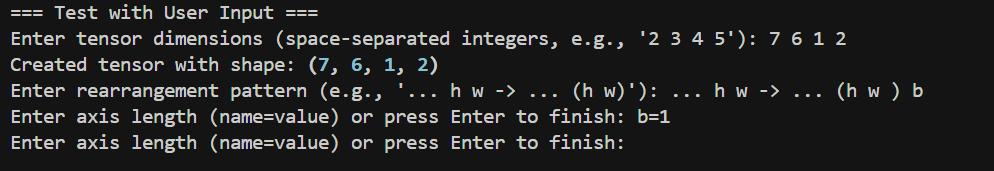

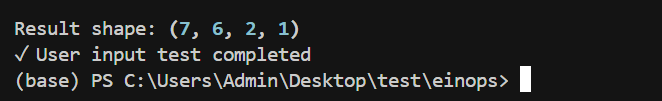

Whole Terminal Output
```py
Running Einops Rearrange Tests
=============================


=== Test with User Input ===
Enter tensor dimensions (space-separated integers, e.g., '2 3 4 5'): 7 6 1 2
Created tensor with shape: (7, 6, 1, 2)
Enter rearrangement pattern (e.g., '... h w -> ... (h w)'): ... h w -> ... (h w ) b
Enter axis length (name=value) or press Enter to finish: b=1
Enter axis length (name=value) or press Enter to finish:

=== Debug: Starting rearrange ===
Pattern: ... h w -> ... (h w ) b
Input tensor shape: (7, 6, 1, 2)
Axes lengths: {'b': 1}
Parsed input nodes: [..., h, w]
Parsed output nodes: [..., (h w), b]
    Debug _infer_transformations:
    Input flat: ['...', '...', 'h', 'w']
    Output flat: ['...', 'h', 'w', 'b']
    Initial existing axes: {'w', '...', 'h'}
    Input groups map: {}
    Input groups: []
    Output groups: [['h', 'w']]
    Found merge operation for group: ['h', 'w']
    Updated input flat after merge: ['...', '...', '(h w)', '(h w)']
    Existing axes after merge/split: {'...', '(h w)'}
    Existing axes after repeat: {'...', '(h w)'}
    Found transpose operation:
    From: ['...', '(h w)']
    To: ['...', '(h w)', 'b']

    Final operations:
    - OperationType.MERGE: ['h', 'w'] -> ['h', 'w']
    - OperationType.TRANSPOSE: ['...', '(h w)'] -> ['...', '(h w)', 'b']

Inferred operations:
  OperationType.MERGE: ['h', 'w'] -> ['h', 'w']
  OperationType.TRANSPOSE: ['...', '(h w)'] -> ['...', '(h w)', 'b']

Initial axis order: ['...', '...', 'h', 'w']

Applying OperationType.MERGE operation:
  Before shape: (7, 6, 1, 2)
  Before axis order: ['...', '...', 'h', 'w']
  After shape: (7, 6, 2)
  After axis order: ['...', '...', '(h w)']

Applying OperationType.TRANSPOSE operation:
  Before shape: (7, 6, 2)
  Before axis order: ['...', '...', '(h w)']
  Debug _apply_transpose:
    Current axis order: ['...', '...', '(h w)']
    Target output axes: ['...', '(h w)', 'b']
    Permutation: [0, 1, 2, 3]
    New axis order: ['...', '...', '(h w)', 'b']
    New shape: [7, 6, 2, 1]
  After shape: (7, 6, 2, 1)
  After axis order: ['...', '...', '(h w)', 'b']

Final result shape: (7, 6, 2, 1)
Final axis order: ['...', '...', '(h w)', 'b']
=== Debug: End rearrange ===

Result shape: (7, 6, 2, 1)
✓ User input test completed
(base) PS C:\Users\Admin\Desktop\test\einops>
```

